## Loading Dataset

In [1]:
#importing required packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Activation, Flatten
import tensorflow as tf
import warnings; warnings.simplefilter('ignore')

In [2]:
#reading dataset

df = pd.read_csv("train.csv", header=0, parse_dates=True)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
#Shape of data

print ('No. of Examples : ',df.shape[0])
print ('No. of Features : ', df.shape[1])

No. of Examples :  1458644
No. of Features :  11


## Checking for datatype and Null Values

In [4]:
#Attribute information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
#checking missing values

df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

<b>Dataset has no null values</b>

## EDA & Data Preprocessing

Text(0.5, 1.0, 'Vendor ID')

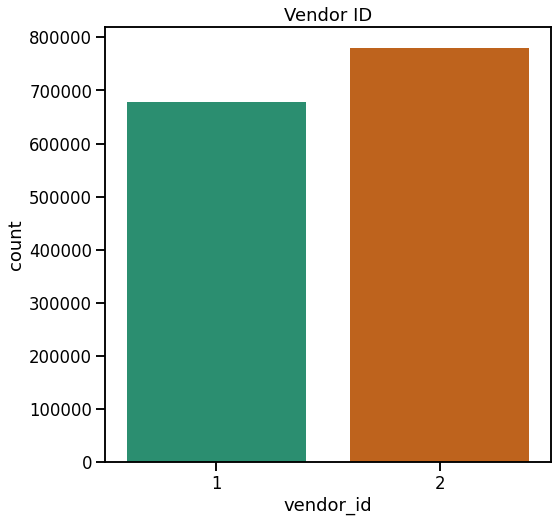

In [6]:
#vendor_id - a code indicating the provider associated with the trip record

sns.set_context('talk')

plt.figure(figsize=(8,8))
sns.countplot(df['vendor_id'], palette='Dark2')
plt.title("Vendor ID")

<b>From Above Visualization, we can say that there are 2 vendors (Service Providers).<br>
2nd Service provider is the most opted one by New Yorkers.</b>

Text(0.5, 1.0, 'Store and Forward Flag')

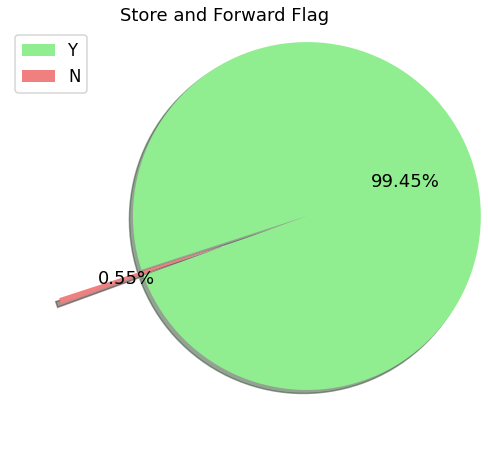

In [7]:
#Store & Forward flag

plt.figure(figsize=(8,8))
plt.pie(df['store_and_fwd_flag'].value_counts(), colors=['lightgreen', 'lightcoral'], shadow=True, explode=[0.5,0], autopct='%1.2f%%', startangle=200)
plt.legend(labels=['Y','N'])
plt.title("Store and Forward Flag")

<b>store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y = store and forward; N = not a store and forward trip.<br>
Visualization tells us that there were very few trips of which the records were stored in memory due to no connection to the server.</b>

In [8]:
#Label Encoding Features having Categorical Values

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
df['store_and_fwd_flag'] = enc.fit_transform(df['store_and_fwd_flag'])
df['vendor_id'] = enc.fit_transform(df['vendor_id'])

#df['vendor_id'] = df['vendor_id'].astype('category')
#df['store_and_fwd_flag'] = df['store_and_fwd_flag'].astype('category')

<b>Conversion of 'store_and_fwd_flag' and 'vendor_id' to be Label encoded as those are Categorical features , binarizing them will help us to compute them with ease.<br>
We can convert these features into “category” type by function called “astype(‘category’)” that will speed up the Computation. Since, my plan is to go with PCA for dimension reduction, I’m not going with that approach.</b>

## Descriptive Statistics

Text(0.5, 1.0, 'Descriptive Stats')

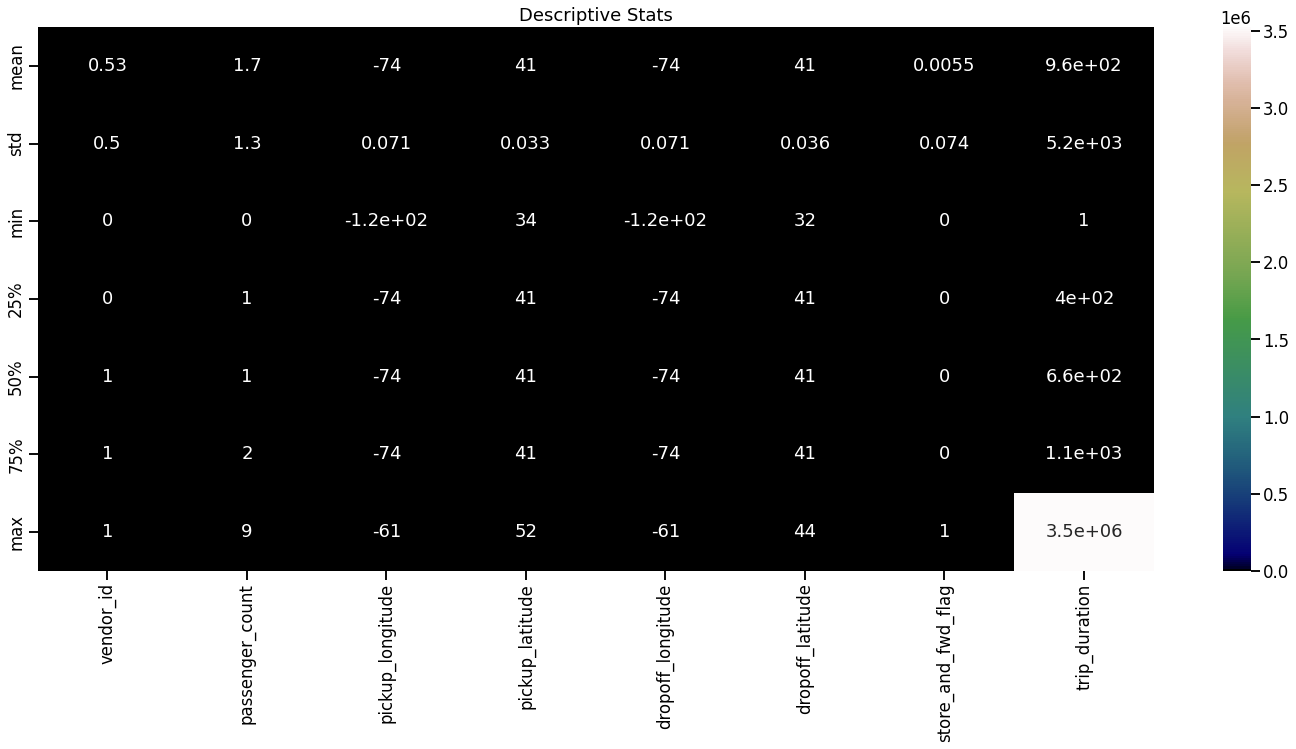

In [9]:
#Descriptive Stats

plt.figure(figsize=(25,10))
sns.heatmap(df.describe()[1:], annot=True, cmap='gist_earth')
plt.title('Descriptive Stats')

<b>We can observe that there were trips having 0 passengers which we can consider as false trip.<br>
Also, there are trips having trip duration upto 3526282 seconds (Approx. 980 hours) which is kind of impossible in a day.</b>

<AxesSubplot:xlabel='trip_duration'>

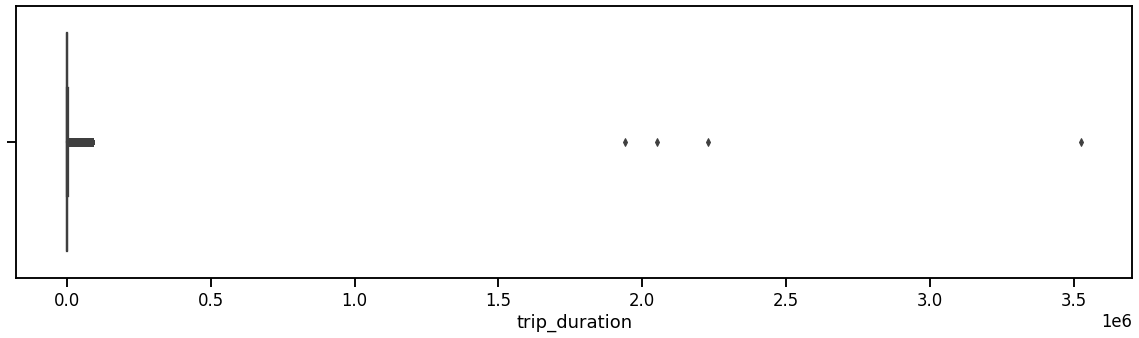

In [10]:
#Visualising Trip duration we can clearly notice few outliers at extreme right

plt.figure(figsize=(20,5))
sns.boxplot(df['trip_duration'])

<b>Probably in this visualization we can clearly see some outliers , their trips are lasting between 1900000 seconds (528 Hours) to somewhere around 3500000 (972 hours) seconds which is impossible in case of taxi trips.<br>
We’ll have to get rid of those Outliers.</b>

Text(0.5, 1.0, 'Passenger Count Distribution')

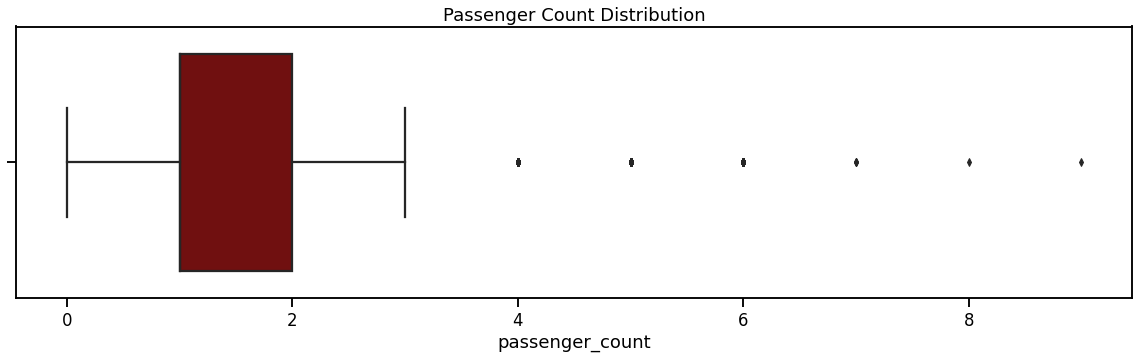

In [11]:
#Spread of Passenger count

plt.figure(figsize=(20,5))
sns.boxplot(df['passenger_count'], color='maroon')
plt.title('Passenger Count Distribution')

<b>Most number of trips are done by 1-2 passenger(s).<br>
There exist trips with Zero passengers it might be a False record<br>
Above 4 Passengers Indicate that the cab must be larger sized.</b>

Text(0.5, 1.0, 'Log Transformed - Trip Duration')

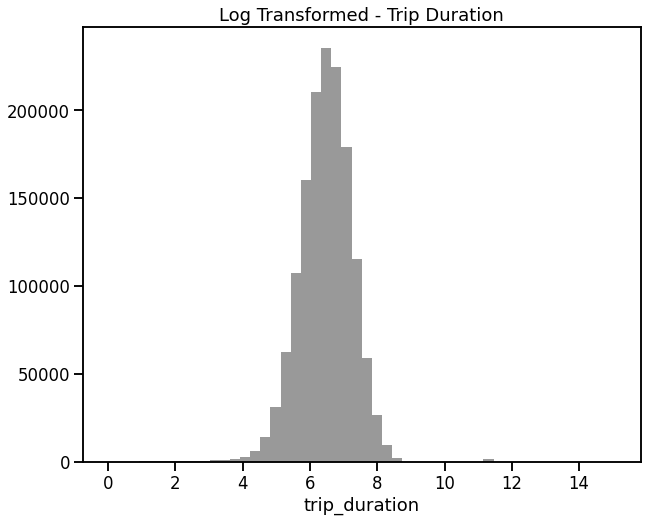

In [12]:
#Log Transformation

plt.figure(figsize=(10,8))
sns.distplot(np.log(df['trip_duration']), kde=False, color='black')
plt.title("Log Transformed - Trip Duration")

<b>Since our Evaluation Metric is RMSLE, we'll proceed further with Log Transformed "Trip duration".<br>
Log Transformation Smoothens outliers by proving them less weightage.</b>

## Geo Spatial Data

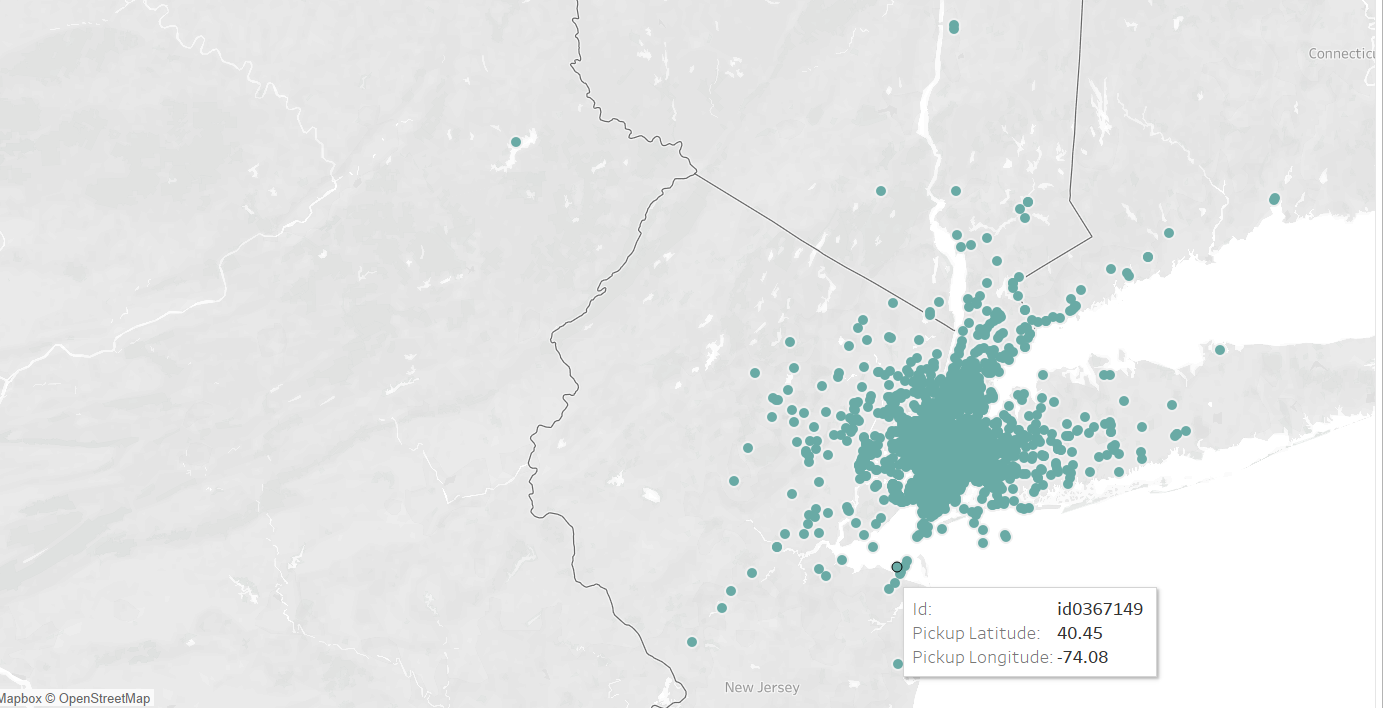

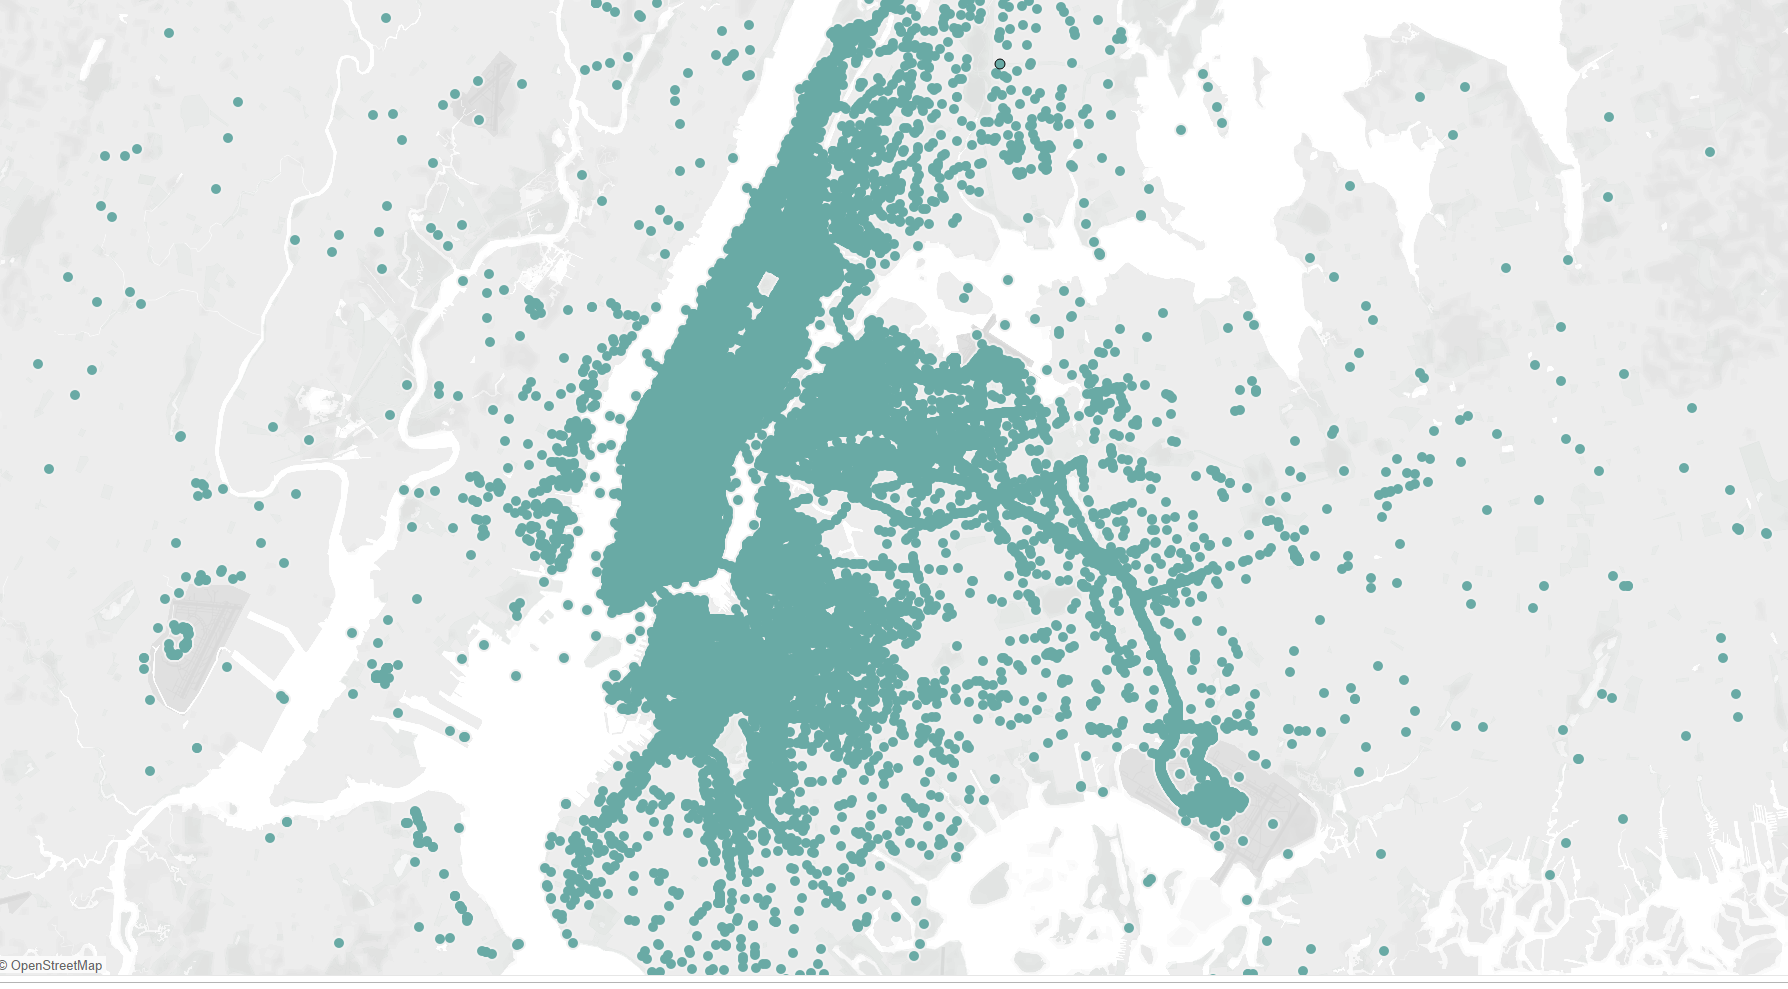

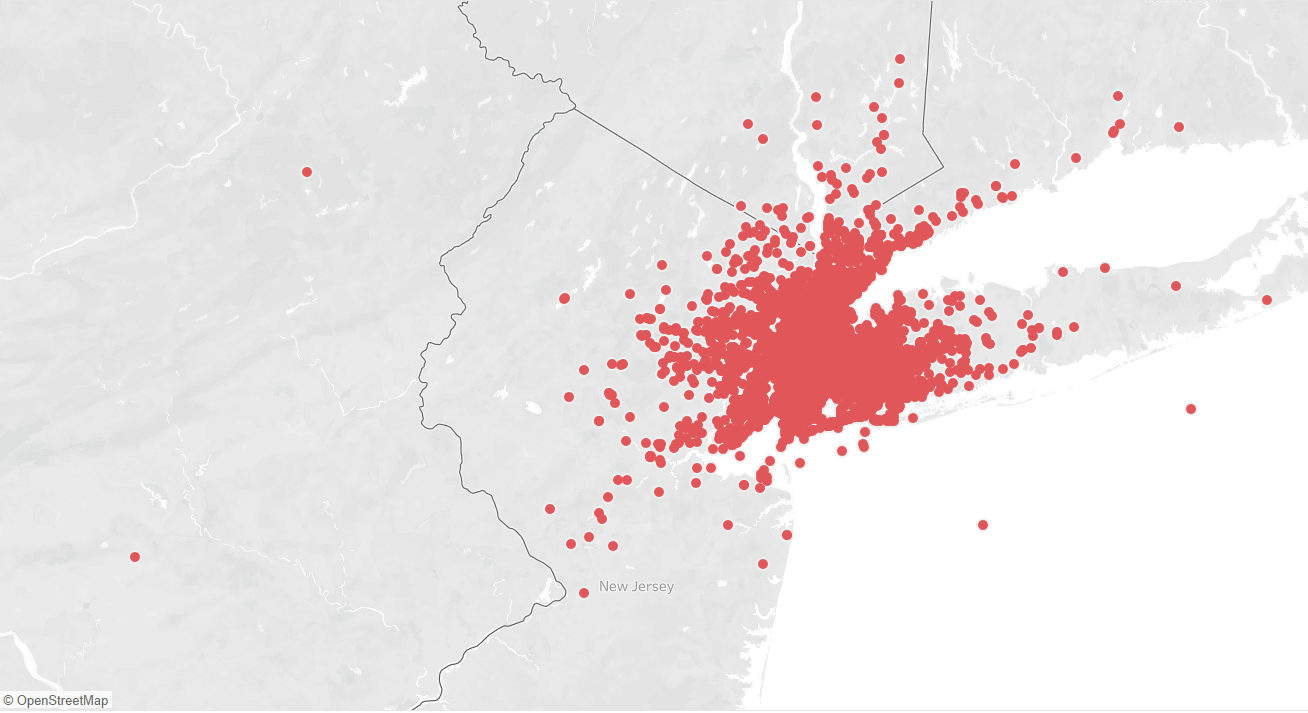

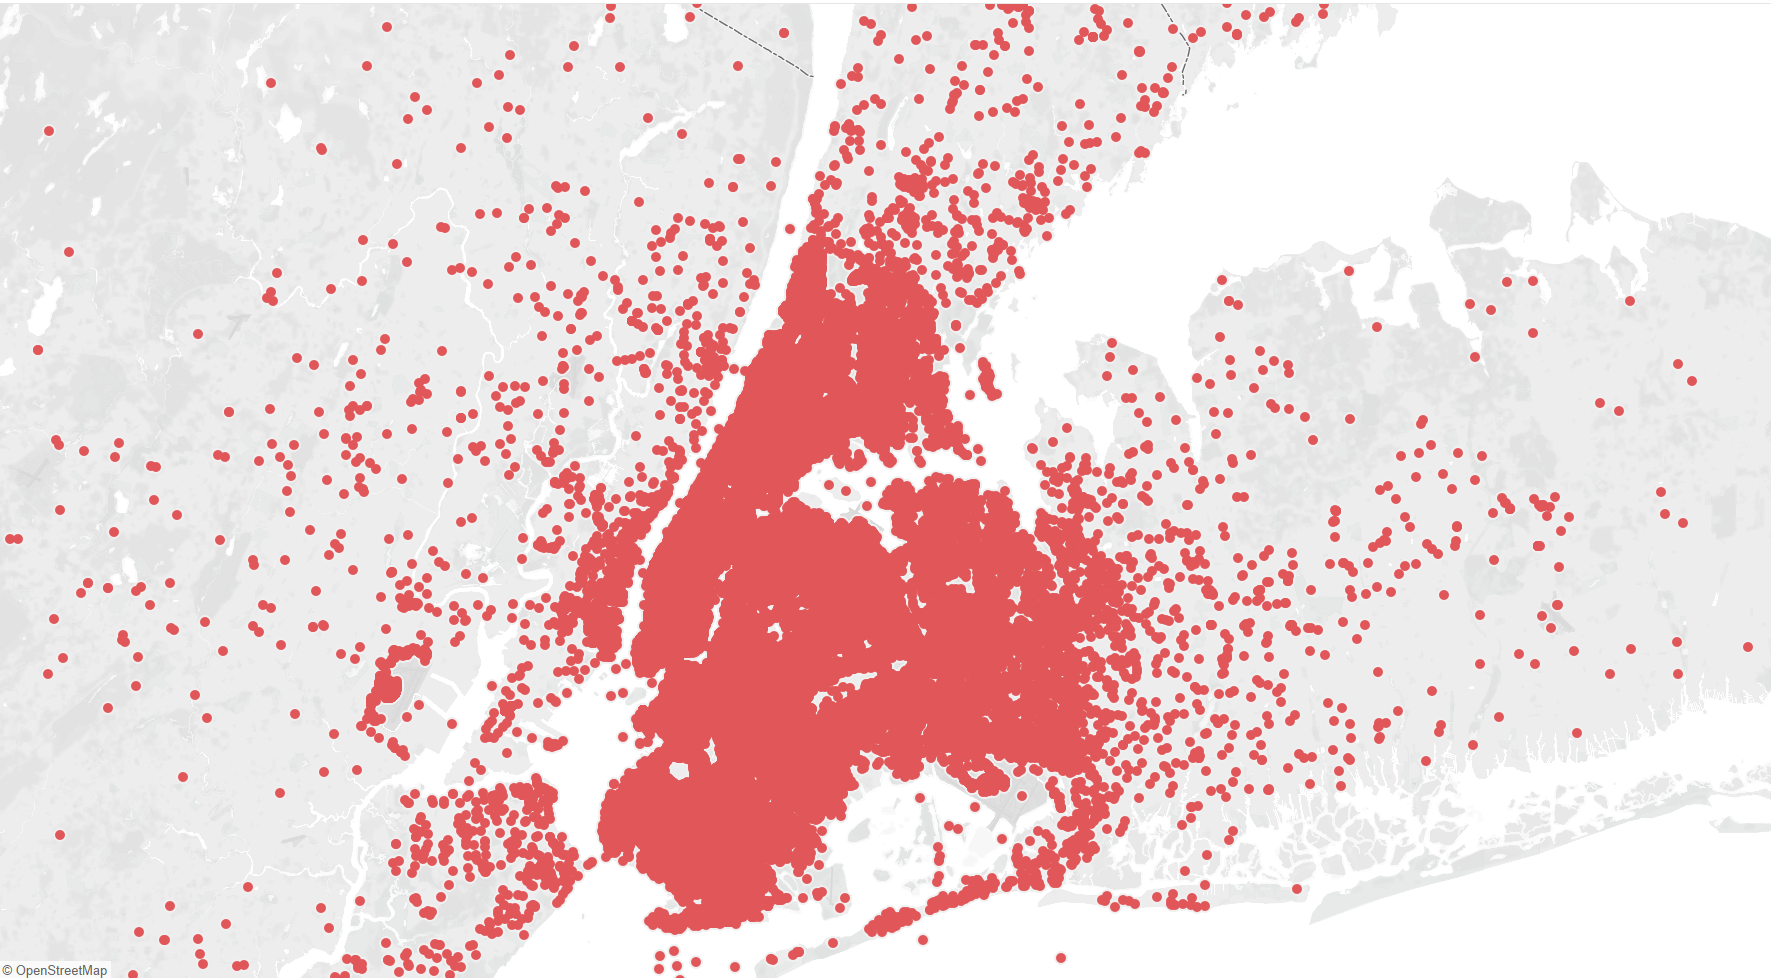

<AxesSubplot:xlabel='passenger_count', ylabel='count'>

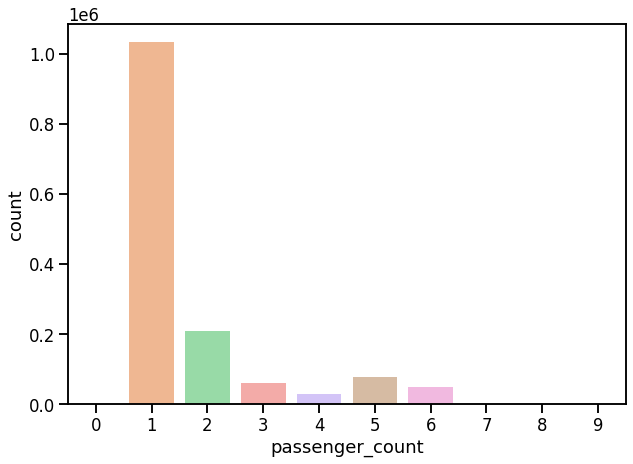

In [13]:
#Passenger count

plt.figure(figsize=(10,7))
sns.countplot(df['passenger_count'], palette='pastel')

<b>There were most number of trips are done by Single passenger.<br>
5 - 9 passengers trip states us that cab must be a Large vehicle.</b>

## Feature Engineering

In [14]:
#Extracting day, month, date, hour, mins, weekday from datetime

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_date'] = df['pickup_datetime'].dt.date
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_min'] = df['pickup_datetime'].dt.minute
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday

df['dropoff_min'] = df['dropoff_datetime'].dt.minute

<b>The Date and time columns in the Dataset has whole lot story to tell, we have to fetch them as separate features.<br>
We do not have to extract pickup and dropoff time both, as they may lead to strong positive correlation between them. (For analysis purpose obviosly we can extract)<br>
Further we can use these columns for Analysis.</b>

In [15]:
# from haversine import haversine
# df['haversine_distance'] = df.apply(lambda r: haversine((r['pickup_latitude'],r['pickup_longitude']),
#                                                                   (r['dropoff_latitude'], r['dropoff_longitude'])),axis=1)
# df['log_haversine_distance'] = np.log(df['haversine_distance'] + 1)

Text(0.5, 1.0, 'Overall Monthly trips')

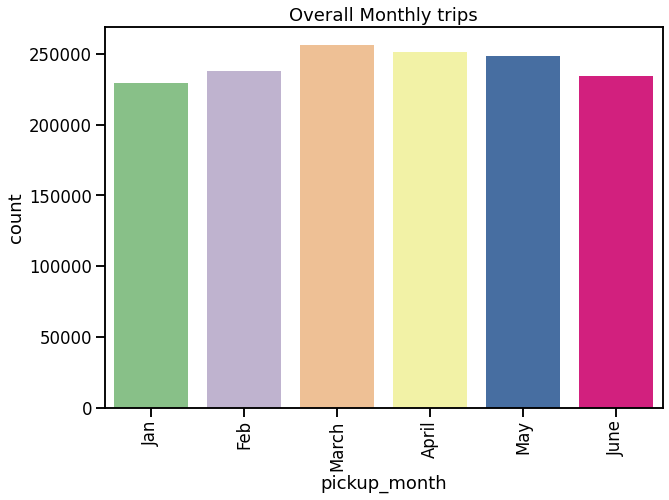

In [16]:
#monthly trips exploration

plt.figure(figsize=(10,7))
sns.countplot(df['pickup_month'], palette='Accent')
plt.xticks([0,1,2,3,4,5], labels=['Jan','Feb','March','April','May','June'], rotation=90)
plt.title('Overall Monthly trips')

<b>We've data of 6 months.<br>
Number of trips in a particular month - March and April marking the highest.<br>
January being lowest probably due to extreme SnowFall NYC.</b>

Text(0.5, 1.0, 'Hourly Pickups')

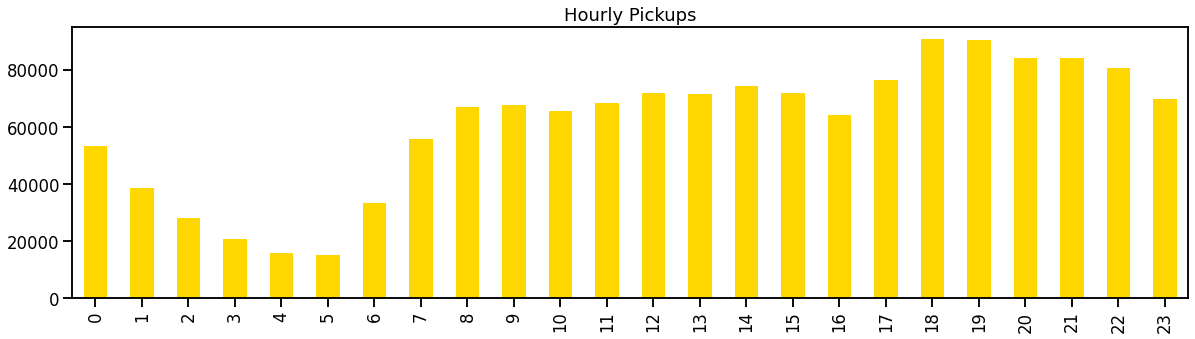

In [17]:
#Analyzing hourly pickups

plt.figure(figsize=(20,5))
pickup_hour = df['pickup_hour'].value_counts()
pickup_hour.sort_index().plot(kind='bar', color='gold')
plt.title("Hourly Pickups")

<b>5pm - 10pm are the busiest hours</b>

Text(0.5, 1.0, 'Overall Week day Trips')

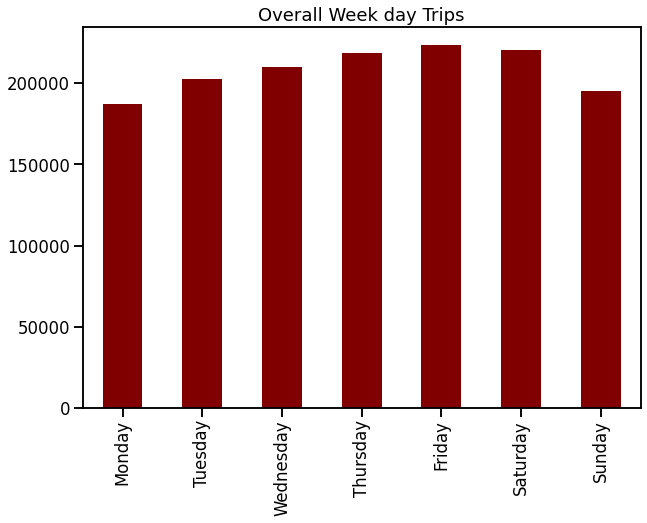

In [18]:
#Analyzing week day trips

plt.figure(figsize=(10,7))
pickup_week = df['pickup_weekday'].value_counts()
pickup_week.sort_index().plot(kind='bar', color='maroon')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=90)
plt.title('Overall Week day Trips')

<b>In New York Friday and Saturday are the busiest days of the week</b>

Text(0.5, 1.0, 'Daily Trips Plot')

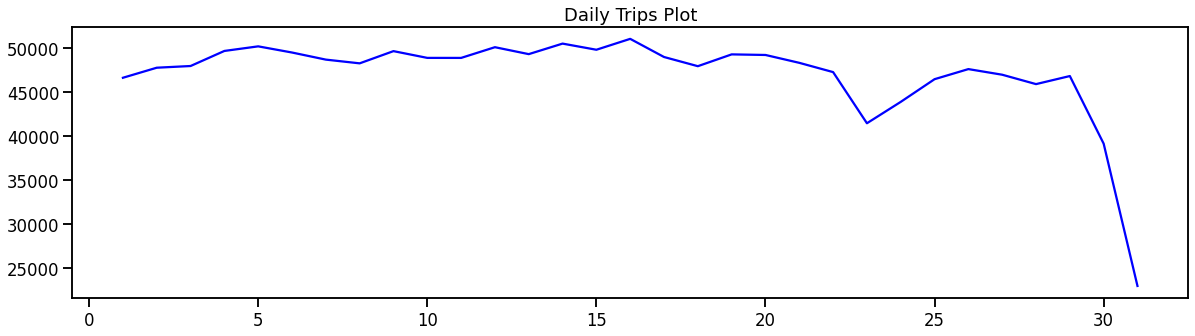

In [19]:
#Examining Daily trip

plt.figure(figsize=(20,5))
pickup_day = df['pickup_day'].value_counts()
pickup_day.sort_index().plot(kind='line', color='blue')
plt.title('Daily Trips Plot')

<b>There is a significant drop in the Taxi trip count as month end’s approach.</b>

## Correlation Heatmap

Text(0.5, 1.0, 'Correlation Plot')

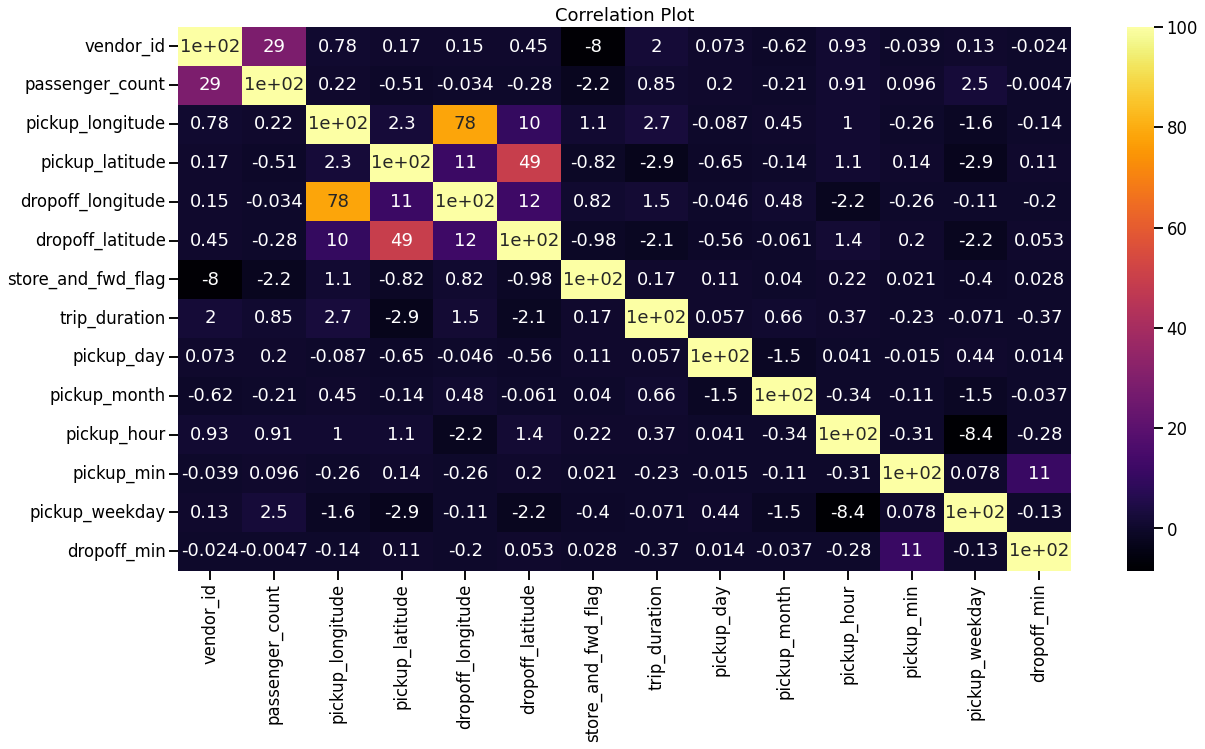

In [20]:
#Plotting Pearson Correlation heatmap

plt.figure(figsize=(20,10))
sns.heatmap(df.corr()*100, annot=True, cmap='inferno')
plt.title('Correlation Plot')

In [21]:
#dropping unwanted columns

nyc_taxi_df = df.drop(['id','pickup_datetime','pickup_date','dropoff_datetime'], axis=1)
nyc_taxi_df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_weekday,dropoff_min
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,14,3,17,24,0,32
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,12,6,0,43,6,54
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,19,1,11,35,1,10
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,429,6,4,19,32,2,39
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,435,26,3,13,30,5,38


## Normalization

In [22]:
#Predictors and Target Variable

X = nyc_taxi_df.drop(['trip_duration'], axis=1)
y = np.log(nyc_taxi_df['trip_duration'])

In [23]:
# Normalising Predictors and creating new dataframe

from sklearn.preprocessing import MinMaxScaler

cols = X.columns

ss = MinMaxScaler()
new_df = ss.fit_transform(X)
new_df = pd.DataFrame(new_df, columns=cols)
new_df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_weekday,dropoff_min
0,1.0,0.111111,0.791302,0.365738,0.791591,0.731222,0.0,0.433333,0.4,0.739130,0.406780,0.000000,0.542373
1,0.0,0.111111,0.791331,0.364062,0.791016,0.728287,0.0,0.366667,1.0,0.000000,0.728814,1.000000,0.915254
2,1.0,0.111111,0.791354,0.365510,0.790920,0.726493,0.0,0.600000,0.0,0.478261,0.593220,0.166667,0.169492
3,1.0,0.111111,0.790842,0.363001,0.790805,0.726206,0.0,0.166667,0.6,0.826087,0.542373,0.333333,0.661017
4,1.0,0.111111,0.791452,0.367181,0.791454,0.732663,0.0,0.833333,0.4,0.565217,0.508475,0.833333,0.644068


## Decomposition using Principal Component Analysis (PCA)

In [24]:
X = new_df

In [25]:
#Applying PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=len(nyc_taxi_df.columns)-1)
pca.fit_transform(X)
var_rat = pca.explained_variance_ratio_
var_rat

array([3.02215392e-01, 1.36817292e-01, 1.29675929e-01, 1.16485691e-01,
       1.01342445e-01, 9.25161015e-02, 9.09842574e-02, 2.33765046e-02,
       6.56760497e-03, 1.26964927e-05, 2.89192766e-06, 2.84756964e-06,
       3.46262283e-07])

<BarContainer object of 13 artists>

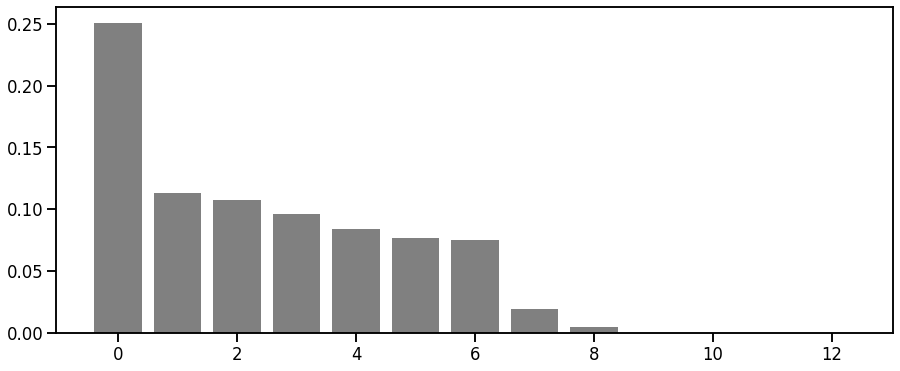

In [26]:
#Variance Ratio vs PC plot

plt.figure(figsize=(15,6))
plt.bar(np.arange(pca.n_components_), pca.explained_variance_, color="grey")

<b>At 7th component our PCA model seems to go Flat without explaining much of a Variance.</b>

Text(0.5, 1.0, 'Elbow Plot')

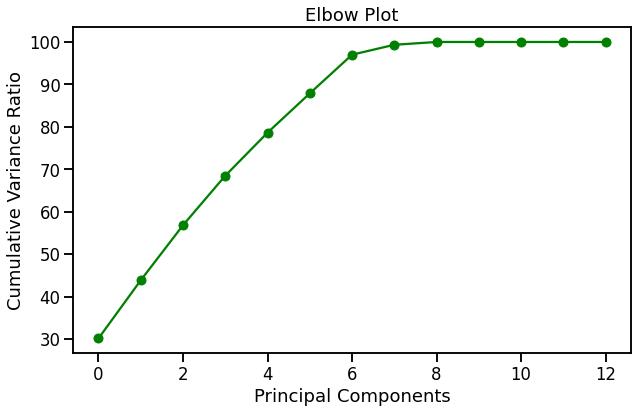

In [27]:
#Cumulative Variance Ratio

plt.figure(figsize=(10,6))
plt.plot(np.cumsum(var_rat)*100, color="g", marker='o')
plt.xlabel("Principal Components")
plt.ylabel("Cumulative Variance Ratio")
plt.title('Elbow Plot')

In [28]:
#Applying PCA as per required components

pca = PCA(n_components=7)
transform = pca.fit_transform(X)
pca.explained_variance_

array([0.25074367, 0.1135153 , 0.10759021, 0.09664647, 0.08408234,
       0.07675925, 0.0754883 ])

<b>We have considered 7 as a required number of components and extracted new features by transforming the Data.</b>

Text(0.5, 1.0, 'Contribution of a Particular feature to our Principal Components')

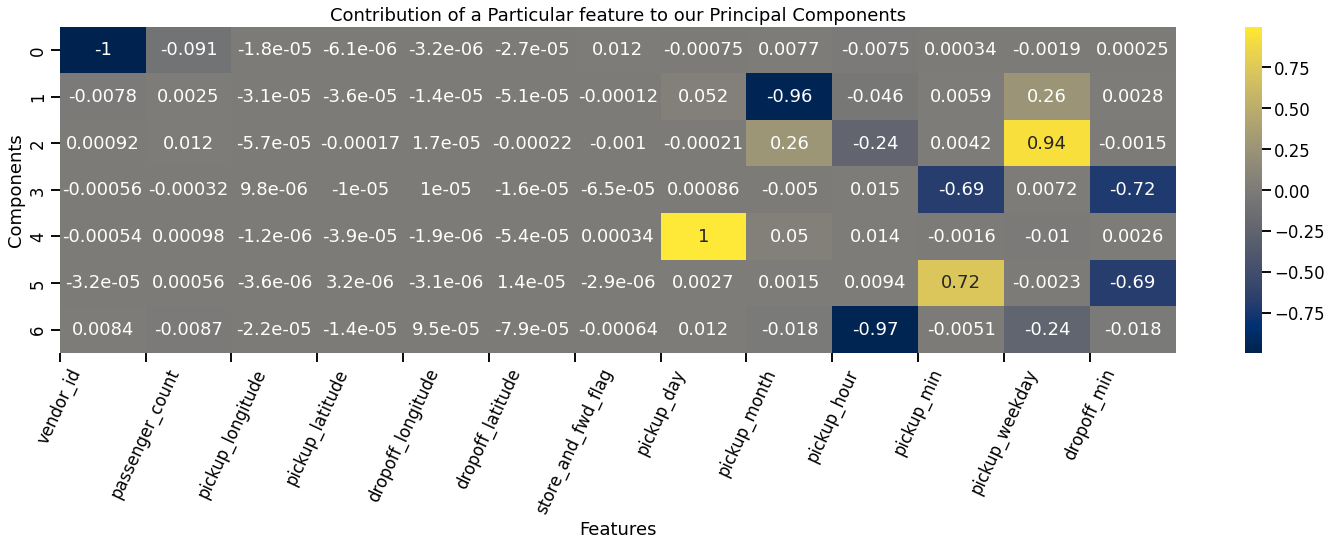

In [29]:
#importance of features in Particular Principal Component

plt.figure(figsize=(25,6))
sns.heatmap(pca.components_, annot=True, cmap="cividis")
plt.ylabel("Components")
plt.xlabel("Features")
plt.xticks(np.arange(len(X.columns)), X.columns, rotation=65)
plt.title('Contribution of a Particular feature to our Principal Components')

<b>Above plot gives us detailed idealogy of which feature has contributed more or less to our each Principal Component.<br>
Pricipal Components are our new features which consists of Information from every other original Feature we have.<br>
We reduce the Dimensions using PCA by retaining as much as Information possible.</b>

## Splitting the data

In [30]:
#Passing in Transformed values as Predictors

X = transform
y = np.log(nyc_taxi_df['trip_duration']).values

In [31]:
#importing train test split & some important metrics

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_log_error , mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1021050, 7), (437594, 7), (1021050,), (437594,))

## 1. Linear Regression

In [32]:
#implementing Linear regression

from sklearn.linear_model import LinearRegression

est_lr = LinearRegression()
est_lr.fit(X_train, y_train)
lr_pred = est_lr.predict(X_test)
lr_pred

array([6.35857672, 6.44519519, 6.46812315, ..., 6.46398426, 6.47092467,
       6.45142821])

In [33]:
#coeficients & intercept

est_lr.intercept_, est_lr.coef_

(6.464225085545506,
 array([-0.03347451, -0.12454297, -0.05217413,  0.02114708,  0.03791679,
        -0.01658303, -0.09221038]))

In [34]:
#examining scores

print ("Training Score : " , est_lr.score(X_train, y_train))

print ("Validation Score : ", est_lr.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_lr, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(lr_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(lr_pred, y_test)))

Training Score :  0.00494127477655204
Validation Score :  0.004820135632710998
Cross Validation Score :  0.004905960955734634
R2_Score :  -199.9136125813191
RMSLE :  0.1143852633818311


Text(0.5, 1.0, 'Test VS Prediction')

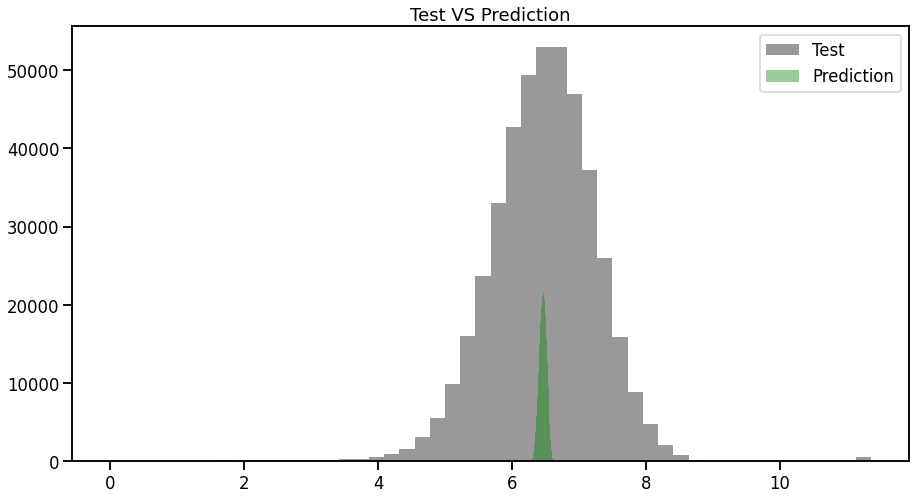

In [35]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(lr_pred, kde=False, color="g", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

<b>Linear Regression isn't performing good.<br>
We can conclude that Linear Regression doesn't seem like a right choice for Trip duration prediction.</b>

## 2. Decision Tree

In [36]:
#implementation of decision tree

from sklearn.tree import DecisionTreeRegressor

est_dt = DecisionTreeRegressor(criterion="mse", max_depth=10)
est_dt.fit(X_train, y_train)
dt_pred = est_dt.predict(X_test)
dt_pred

array([6.49755548, 7.49443079, 6.19351817, ..., 6.99544513, 7.64424492,
       6.50706255])

In [37]:
#examining metrics

print ("Training Score : " , est_dt.score(X_train, y_train))

print ("Validation Score : ", est_dt.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_dt, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(dt_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(dt_pred, y_test)))

Training Score :  0.8712568520532058
Validation Score :  0.8619685134916346
Cross Validation Score :  0.8630324793806858
R2_Score :  0.8421284481573511
RMSLE :  0.04580394526871497


Text(0.5, 1.0, 'Test VS Prediction')

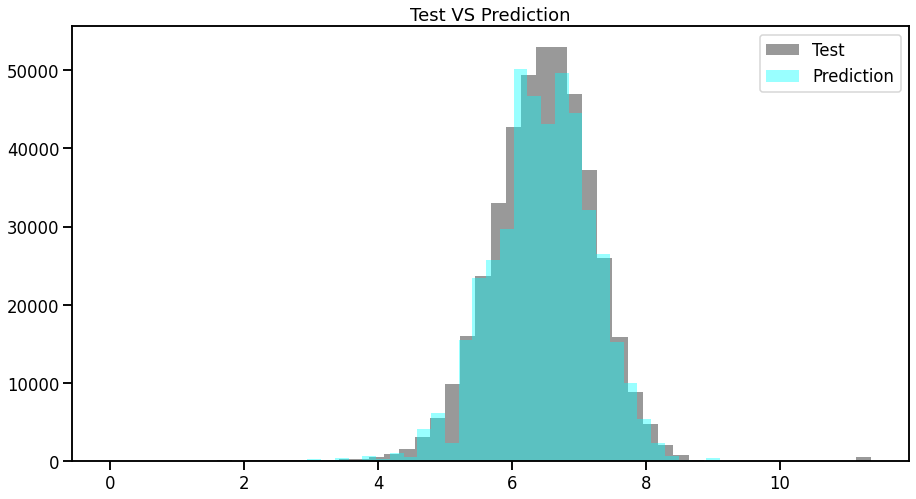

In [38]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(dt_pred, kde=False, color="cyan", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

<b>We can clearly identify that the Decision Tree Algorithm is performing good.<br>
We can conclude that Decision Tree could be a good choice for Trip duration prediction.</b>

## 3. Random Forest

In [39]:
#random forest implementation

from sklearn.ensemble import RandomForestRegressor

est_rf = RandomForestRegressor(criterion="mse", n_estimators=5, max_depth=10)
est_rf.fit(X_train, y_train)
rf_pred = est_rf.predict(X_test)
rf_pred

array([6.52827007, 7.48364217, 6.22449148, ..., 6.99273493, 7.65680446,
       6.50532731])

In [40]:
#examining metrics 

print ("Training Score : " , est_rf.score(X_train, y_train))

print ("Validation Score : ", est_rf.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_rf, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(rf_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(rf_pred, y_test)))

Training Score :  0.878547282548698
Validation Score :  0.8701956340473157
Cross Validation Score :  0.8700230804808349
R2_Score :  0.8508276036963947
RMSLE :  0.044332667993916115


Text(0.5, 1.0, 'Test VS Prediction')

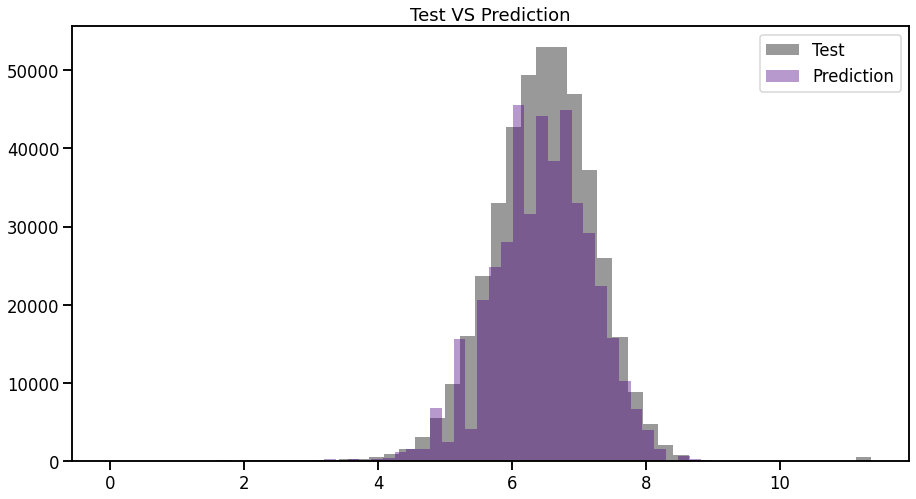

In [41]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(rf_pred, kde=False, color="indigo", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

<b>We can clearly identify that the Random Forest Algorithm is performing good.<br>
We can conclude that Random Forest could be a good choice for Trip duration prediction.</b>

## 4. Deep Neural Network

In [42]:
# Building the neural network
from tensorflow.keras.optimizers import Adam

model = Sequential()

# The Input Layer :
model.add(Dense(256, activation='relu', input_dim=X_train.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())

# The Hidden Layers :
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())

# The Output Layer :
model.add(Dense(1))

#adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,)
model.compile(loss='mse', optimizer= 'adam', metrics=['mse'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2048      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               2

In [43]:
# Checkpoints
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.3f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [44]:
# Training the DNN
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=20, verbose=1, shuffle=False, validation_split = 0.2,callbacks=callbacks_list)

Epoch 1/20
3184/3191 [============================>.] - ETA: 0s - loss: 3.6970 - mse: 3.6729
Epoch 00001: val_loss improved from inf to 0.11849, saving model to Weights-001--0.118.hdf5
3191/3191 [==============================] - 15s 4ms/step - loss: 3.6895 - mse: 3.6654 - val_loss: 0.1185 - val_mse: 0.1097
Epoch 2/20
3184/3191 [============================>.] - ETA: 0s - loss: 0.1148 - mse: 0.1067
Epoch 00002: val_loss improved from 0.11849 to 0.10493, saving model to Weights-002--0.105.hdf5
3191/3191 [==============================] - 15s 5ms/step - loss: 0.1149 - mse: 0.1068 - val_loss: 0.1049 - val_mse: 0.0975
Epoch 3/20
3183/3191 [============================>.] - ETA: 0s - loss: 0.1075 - mse: 0.1003
Epoch 00003: val_loss did not improve from 0.10493
3191/3191 [==============================] - 16s 5ms/step - loss: 0.1076 - mse: 0.1003 - val_loss: 0.1391 - val_mse: 0.1323
Epoch 4/20
3180/3191 [============================>.] - ETA: 0s - loss: 0.1035 - mse: 0.0968
Epoch 00004: val_

In [46]:
wights_file = 'Weights-020--0.079.hdf5' # choose the best checkpoint 
model.load_weights(wights_file) # load it
model.compile(loss='mse', optimizer= 'adam', metrics=['mse'])

In [47]:
# Testing the DNN
model_pred= model.predict(X_test)
model_pred

array([[6.441473 ],
       [7.4814825],
       [6.1506505],
       ...,
       [7.061176 ],
       [7.668103 ],
       [6.5218506]], dtype=float32)

In [48]:
#examining metrics 

print ("Training Score : " , model.evaluate(X_train, y_train))

print ("Validation Score : ", model.evaluate(X_test, y_test))

#print ("Cross Validation Score : " , cross_val_score(model, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(model_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(model_pred, y_test)))

31908/31908 [==============================] - 42s 1ms/step - loss: 0.0827 - mse: 0.0770
Training Score :  [0.08265604078769684, 0.07700443267822266]
13675/13675 [==============================] - 18s 1ms/step - loss: 0.0827 - mse: 0.0770
Validation Score :  [0.08266479521989822, 0.07702309638261795]
R2_Score :  0.8630663023146026
RMSLE :  0.042204244064031636


Text(0.5, 1.0, 'Test VS Prediction')

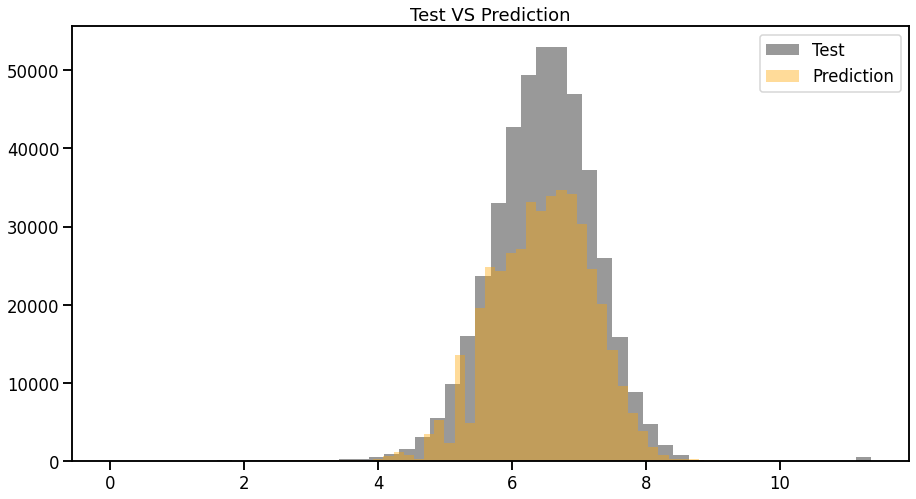

In [49]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(model_pred, kde=False, color="orange", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

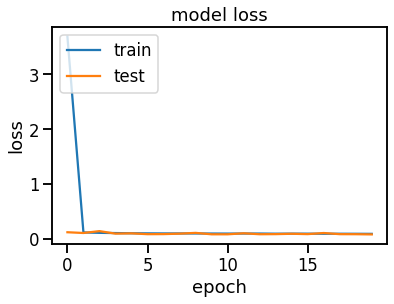

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<b>We can clearly identify that our DNN is performing good.<br>
We can conclude that our DNN could be a good choice for Trip duration prediction.</b>

## R2 Scores Evaluation

Text(0.5, 1.0, 'R2 Scores')

<Figure size 720x504 with 0 Axes>

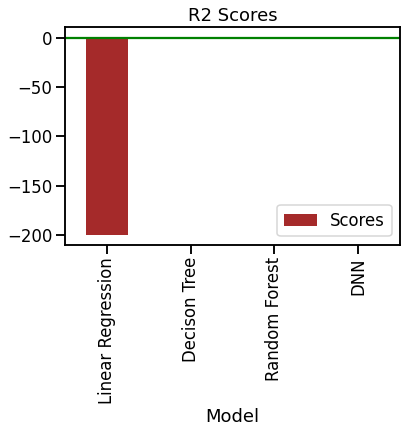

In [51]:
#r2 score plot for all 4 models

plt.figure(figsize=(10,7))
r2 = pd.DataFrame({'Scores':np.array([r2_score(lr_pred, y_test), r2_score(dt_pred, y_test), r2_score(rf_pred, y_test),r2_score(model_pred, y_test)]), 'Model':np.array(['Linear Regression', 'Decison Tree', 'Random Forest', 'DNN'])})
r2.set_index('Model').plot(kind="bar", color="brown")
plt.axhline(y=0, color='g')
plt.title("R2 Scores")

Text(0.5, 1.0, 'R2 Scores')

<Figure size 720x504 with 0 Axes>

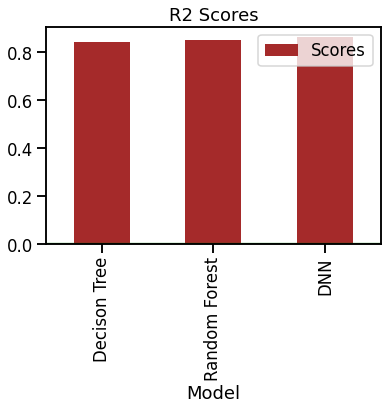

In [52]:
#r2 score plot for 3 models

plt.figure(figsize=(10,7))
r2 = pd.DataFrame({'Scores':np.array([r2_score(dt_pred, y_test), r2_score(rf_pred, y_test),r2_score(model_pred, y_test)]), 'Model':np.array(['Decison Tree', 'Random Forest', 'DNN'])})
r2.set_index('Model').plot(kind="bar", color="brown")
plt.axhline(y=0, color='g')
plt.title("R2 Scores")

## RMSLE Evaluation

Text(0.5, 1.0, 'RMSLE - Lesser is Better')

<Figure size 720x720 with 0 Axes>

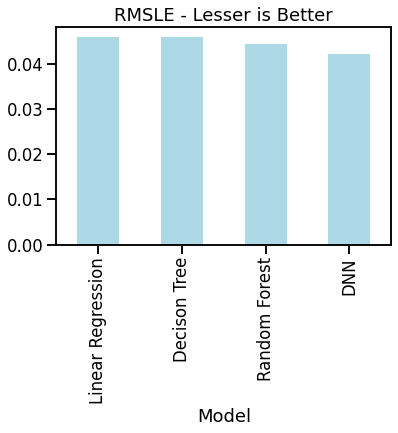

In [53]:
#RMSLE plot

plt.figure(figsize=(10,10))
r2 = pd.DataFrame({'RMSLE':np.array([np.sqrt(mean_squared_log_error(dt_pred, y_test)),np.sqrt(mean_squared_log_error(dt_pred, y_test)), np.sqrt(mean_squared_log_error(rf_pred, y_test)),np.sqrt(mean_squared_log_error(model_pred, y_test))]), 'Model':np.array(['Linear Regression','Decison Tree', 'Random Forest','DNN'])})
r2.set_index('Model').plot(kind="bar", color="lightblue", legend=False)
plt.title("RMSLE - Lesser is Better")

## Without PCA

<b>In this approach instead of using PCA, we have used Min-Max Scaling on the Dataset and applied our Algorithms.</b>

In [54]:
X = new_df
y = np.log(nyc_taxi_df['trip_duration']).values

In [55]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

## 1. Linear Regression

In [56]:
#implenting linear regression

est_lr = LinearRegression()
est_lr.fit(X_train, y_train)
lr_pred = est_lr.predict(X_test)
lr_pred

array([6.40343909, 6.41676214, 6.59381897, ..., 6.49082468, 6.42025967,
       6.52937071])

In [57]:
#Intercept & Coef

est_lr.intercept_, est_lr.coef_

(-15.568045012307824,
 array([ 2.67206540e-02,  8.93834797e-02,  7.40223854e+01, -4.54299944e+01,
        -3.96016209e+00, -2.32350250e+01,  1.41613804e-01,  2.70295731e-02,
         1.07747238e-01,  1.10312587e-01, -2.60038204e-02, -6.72204998e-02,
        -2.13555458e-03]))

In [58]:
#Examining metrics

print ("Training Score : " , est_lr.score(X_train, y_train))

print ("Validation Score : ", est_lr.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_lr, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(lr_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(lr_pred, y_test)))

Training Score :  0.04347306142666174
Validation Score :  0.04509248495913365
Cross Validation Score :  -0.04870111915032034
R2_Score :  -22.45617356992206
RMSLE :  0.1122823595068526


Text(0.5, 1.0, 'Test VS Prediction')

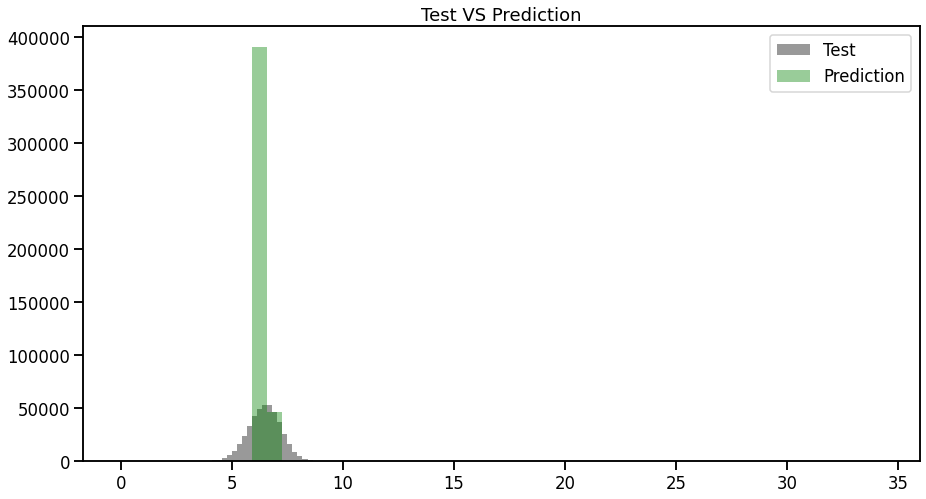

In [59]:
#prediction vs validation data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(lr_pred, kde=False, color="g", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

## 2.Decision Tree

In [60]:
#decision tree implementation

est_dt = DecisionTreeRegressor(criterion="mse", max_depth=10)
est_dt.fit(X_train, y_train)
dt_pred = est_dt.predict(X_test)
dt_pred

array([6.03181348, 7.19929987, 6.45313603, ..., 6.15490363, 7.19929987,
       7.17617183])

In [61]:
#examining metrics

print ("Training Score : " , est_dt.score(X_train, y_train))

print ("Validation Score : ", est_dt.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_dt, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(dt_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(dt_pred, y_test)))

Training Score :  0.46425491774707794
Validation Score :  0.45796441576267277
Cross Validation Score :  0.45764339126306214
R2_Score :  -0.16145635891001775
RMSLE :  0.08783455282420716


Text(0.5, 1.0, 'Test VS Prediction')

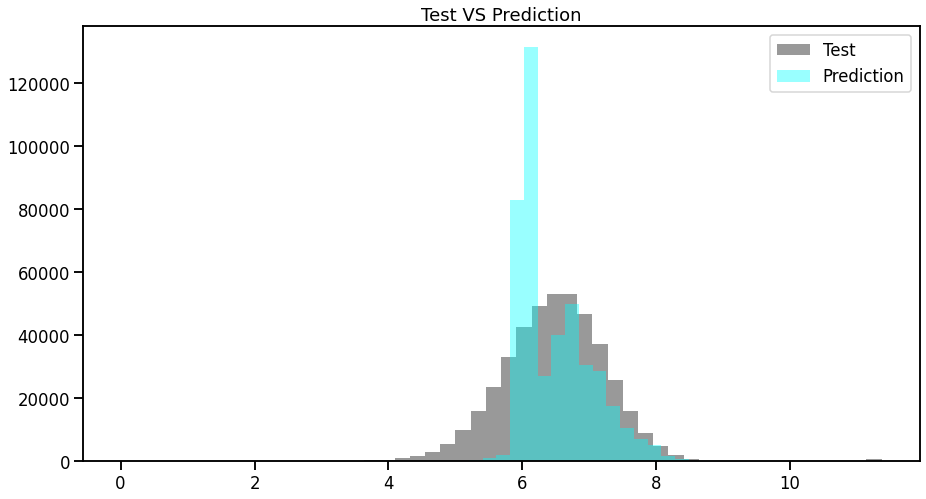

In [62]:
#prediction vs reality check

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(dt_pred, kde=False, color="cyan", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

## 3. Random Forest

In [63]:
#implementation of forest algorithm

from sklearn.ensemble import RandomForestRegressor

est_rf = RandomForestRegressor(criterion="mse", n_estimators=5, max_depth=10)
est_rf.fit(X_train, y_train)
rf_pred = est_rf.predict(X_test)
rf_pred

array([6.09277995, 7.20525445, 6.16863432, ..., 6.1958684 , 7.20525445,
       7.16049096])

In [64]:
#examining metrics

print ("Training Score : " , est_rf.score(X_train, y_train))

print ("Validation Score : ", est_rf.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_rf, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(rf_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(rf_pred, y_test)))

Training Score :  0.4788606538570509
Validation Score :  0.47361415125942075
Cross Validation Score :  0.4705586724468188
R2_Score :  -0.20879998910966302
RMSLE :  0.08682384801988101


Text(0.5, 1.0, 'Test VS Prediction')

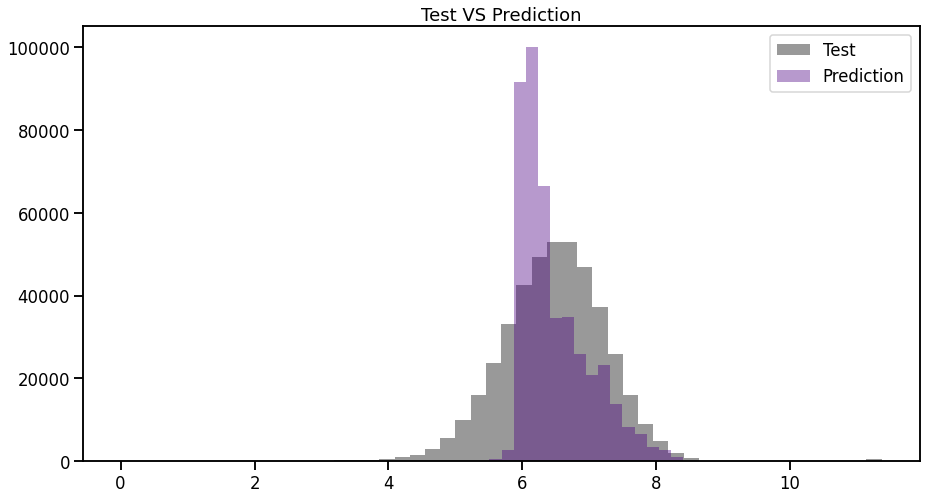

In [65]:
#prediction vs reality check

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(rf_pred, kde=False, color="indigo", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

## 4. Deep Neural Network

In [66]:
# Building the neural network

model = Sequential()

# The Input Layer :
model.add(Dense(256, activation='relu', input_dim=X_train.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())

# The Hidden Layers :
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())

# The Output Layer :
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               3584      
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_7 (Batc  (None, 64)              

In [67]:
# Checkpoints
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.3f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [68]:
# Training the DNN
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=20, verbose=1, shuffle=False, validation_split = 0.2,callbacks=callbacks_list)

Epoch 1/20
3185/3191 [============================>.] - ETA: 0s - loss: 3.7064 - mse: 3.6886
Epoch 00001: val_loss improved from inf to 0.10291, saving model to Weights-001--0.103.hdf5
3191/3191 [==============================] - 15s 4ms/step - loss: 3.6998 - mse: 3.6820 - val_loss: 0.1029 - val_mse: 0.0980
Epoch 2/20
3186/3191 [============================>.] - ETA: 0s - loss: 0.1189 - mse: 0.1150
Epoch 00002: val_loss did not improve from 0.10291
3191/3191 [==============================] - 15s 5ms/step - loss: 0.1190 - mse: 0.1150 - val_loss: 0.1351 - val_mse: 0.1316
Epoch 3/20
3183/3191 [============================>.] - ETA: 0s - loss: 0.1124 - mse: 0.1089
Epoch 00003: val_loss improved from 0.10291 to 0.10121, saving model to Weights-003--0.101.hdf5
3191/3191 [==============================] - 16s 5ms/step - loss: 0.1123 - mse: 0.1089 - val_loss: 0.1012 - val_mse: 0.0979
Epoch 4/20
3185/3191 [============================>.] - ETA: 0s - loss: 0.1119 - mse: 0.1084
Epoch 00004: val_

In [70]:
wights_file = 'Weights-012--0.086.hdf5' # choose the best checkpoint 
model.load_weights(wights_file) # load it
model.compile(loss='mse', optimizer= 'adam', metrics=['mse'])

In [71]:
# Testing the DNN
model_pred= model.predict(X_test)
model_pred

array([[6.460884 ],
       [7.440692 ],
       [6.1616144],
       ...,
       [7.0368633],
       [7.7092676],
       [6.4708104]], dtype=float32)

In [72]:
#examining metrics 

print ("Training Score : " , model.evaluate(X_train, y_train))

print ("Validation Score : ", model.evaluate(X_test, y_test))

#print ("Cross Validation Score : " , cross_val_score(model, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(model_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(model_pred, y_test)))

31908/31908 [==============================] - 42s 1ms/step - loss: 0.0906 - mse: 0.0878
Training Score :  [0.0906437560915947, 0.08781851083040237]
13675/13675 [==============================] - 19s 1ms/step - loss: 0.0905 - mse: 0.0877
Validation Score :  [0.09051334112882614, 0.08769014477729797]
R2_Score :  0.8295695253216858
RMSLE :  0.0467399326198329


Text(0.5, 1.0, 'Test VS Prediction')

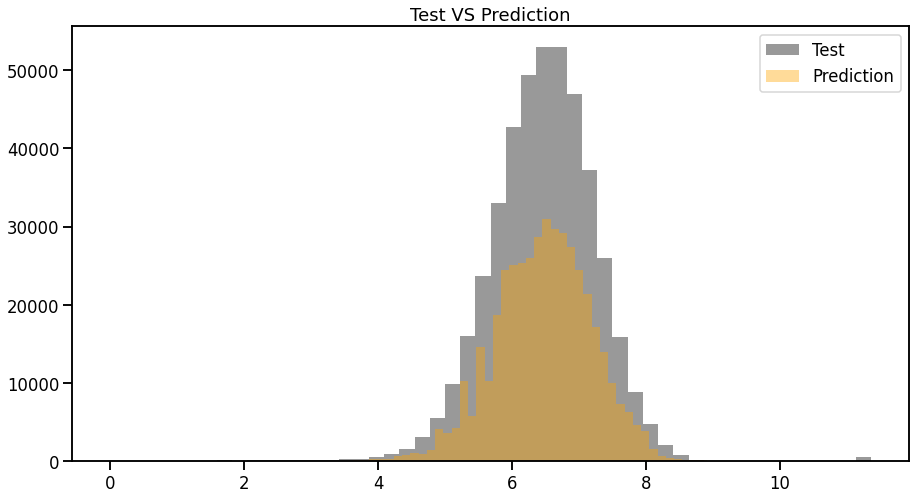

In [73]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(model_pred, kde=False, color="orange", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

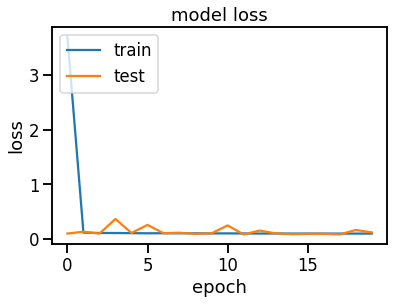

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'R2 Scores')

<Figure size 720x504 with 0 Axes>

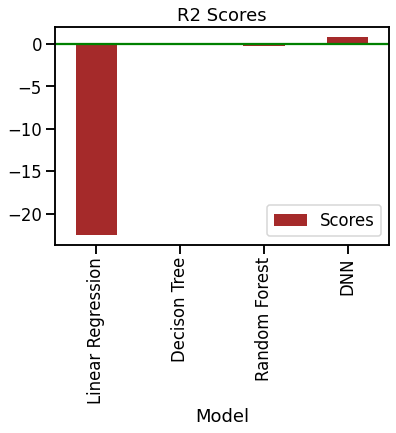

In [75]:
#r2 score plot for all 4 models

plt.figure(figsize=(10,7))
r2 = pd.DataFrame({'Scores':np.array([r2_score(lr_pred, y_test), r2_score(dt_pred, y_test), r2_score(rf_pred, y_test),r2_score(model_pred, y_test)]), 'Model':np.array(['Linear Regression', 'Decison Tree', 'Random Forest', 'DNN'])})
r2.set_index('Model').plot(kind="bar", color="brown")
plt.axhline(y=0, color='g')
plt.title("R2 Scores")

Text(0.5, 1.0, 'R2 Scores')

<Figure size 720x504 with 0 Axes>

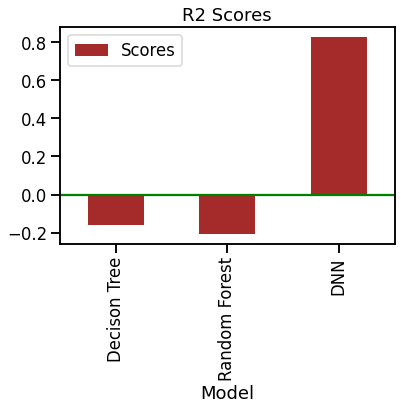

In [76]:
#r2 score plot for 3 models

plt.figure(figsize=(10,7))
r2 = pd.DataFrame({'Scores':np.array([r2_score(dt_pred, y_test), r2_score(rf_pred, y_test),r2_score(model_pred, y_test)]), 'Model':np.array(['Decison Tree', 'Random Forest', 'DNN'])})
r2.set_index('Model').plot(kind="bar", color="brown")
plt.axhline(y=0, color='g')
plt.title("R2 Scores")

Text(0.5, 1.0, 'RMSLE - Lesser is Better')

<Figure size 720x720 with 0 Axes>

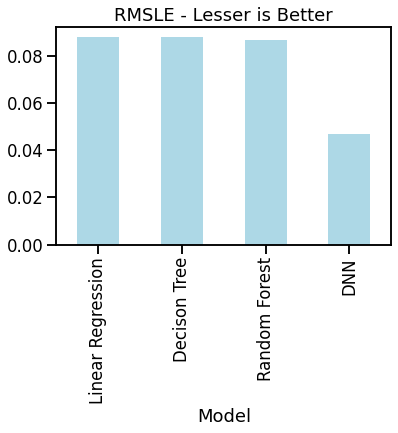

In [77]:
#RMSLE plot

plt.figure(figsize=(10,10))
r2 = pd.DataFrame({'RMSLE':np.array([np.sqrt(mean_squared_log_error(dt_pred, y_test)),np.sqrt(mean_squared_log_error(dt_pred, y_test)), np.sqrt(mean_squared_log_error(rf_pred, y_test)),np.sqrt(mean_squared_log_error(model_pred, y_test))]), 'Model':np.array(['Linear Regression','Decison Tree', 'Random Forest','DNN'])})
r2.set_index('Model').plot(kind="bar", color="lightblue", legend=False)
plt.title("RMSLE - Lesser is Better")

## With Feature Selection

In [177]:
# load data
X = new_df
y = np.log(nyc_taxi_df['trip_duration']).values

In [178]:
from haversine import haversine
X['haversine_distance'] = X.apply(lambda r: haversine((r['pickup_latitude'],r['pickup_longitude']),
                                                                  (r['dropoff_latitude'], r['dropoff_longitude'])),axis=1)

In [179]:
from sklearn.feature_selection import mutual_info_regression

# Determine mutual information
mutual_info = mutual_info_regression(X,y)
mutual_info

array([0.00247787, 0.00078028, 0.07982926, 0.06617076, 0.06305832,
       0.07089989, 0.00096388, 0.00026208, 0.00304968, 0.01312325,
       0.00055846, 0.0034272 , 0.        , 0.21980973])

In [180]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

haversine_distance    0.219810
pickup_longitude      0.079829
dropoff_latitude      0.070900
pickup_latitude       0.066171
dropoff_longitude     0.063058
pickup_hour           0.013123
pickup_weekday        0.003427
pickup_month          0.003050
vendor_id             0.002478
store_and_fwd_flag    0.000964
passenger_count       0.000780
pickup_min            0.000558
pickup_day            0.000262
dropoff_min           0.000000
dtype: float64

<AxesSubplot:>

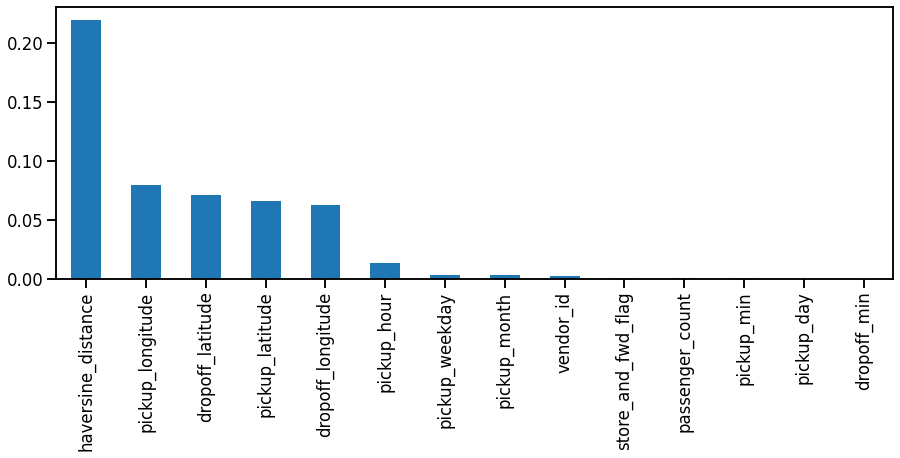

In [181]:
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,5))

In [182]:
X = X.drop(['passenger_count','vendor_id','store_and_fwd_flag','pickup_longitude','dropoff_latitude','pickup_latitude','dropoff_longitude'], axis=1)
X.head()

,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_weekday,dropoff_min,haversine_distance
0,0.433333,0.4,0.739130,0.406780,0.000000,0.542373,40.639988
1,0.366667,1.0,0.000000,0.728814,1.000000,0.915254,40.500100
2,0.600000,0.0,0.478261,0.593220,0.166667,0.169492,40.139559
3,0.166667,0.6,0.826087,0.542373,0.333333,0.661017,40.386660
4,0.833333,0.4,0.565217,0.508475,0.833333,0.644068,40.639833


In [183]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

In [184]:
#implenting linear regression

est_lr = LinearRegression()
est_lr.fit(X_train, y_train)
lr_pred = est_lr.predict(X_test)
lr_pred

array([6.35494476, 6.48695282, 6.46811582, ..., 6.47678272, 6.47547643,
       6.43828909])

In [185]:
#Intercept & Coef

est_lr.intercept_, est_lr.coef_

(10.972606741877744,
 array([ 0.03002195,  0.10939802,  0.10994329, -0.0270325 , -0.05883081,
        -0.0025125 , -0.11321044]))

In [186]:
#Examining metrics

print ("Training Score : " , est_lr.score(X_train, y_train))

print ("Validation Score : ", est_lr.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_lr, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(lr_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(lr_pred, y_test)))

Training Score :  0.006214399567749718
Validation Score :  0.0059606825019422605
Cross Validation Score :  0.006170098234869803
R2_Score :  -159.7414660962917
RMSLE :  0.11434730936675207


Text(0.5, 1.0, 'Test VS Prediction')

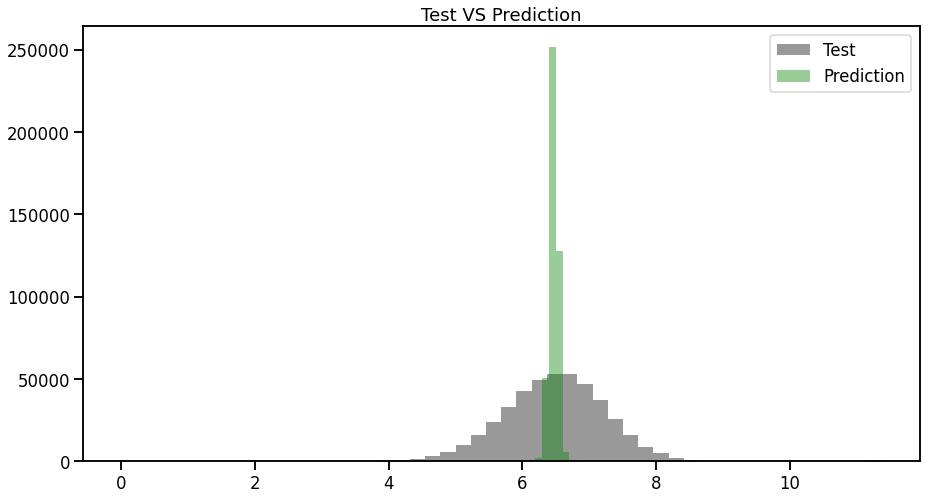

In [187]:
#prediction vs validation data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(lr_pred, kde=False, color="g", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

In [188]:
#decision tree implementation

est_dt = DecisionTreeRegressor(criterion="mse", max_depth=10)
est_dt.fit(X_train, y_train)
dt_pred = est_dt.predict(X_test)
dt_pred

array([6.0144028 , 6.8114508 , 6.09848696, ..., 6.27020534, 6.71969952,
       6.80888712])

In [189]:
#examining metrics

print ("Training Score : " , est_dt.score(X_train, y_train))

print ("Validation Score : ", est_dt.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_dt, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(dt_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(dt_pred, y_test)))

Training Score :  0.31537432099340823
Validation Score :  0.30719009743175285
Cross Validation Score :  0.30666227293578513
R2_Score :  -1.1936983797128198
RMSLE :  0.098150045571475


Text(0.5, 1.0, 'Test VS Prediction')

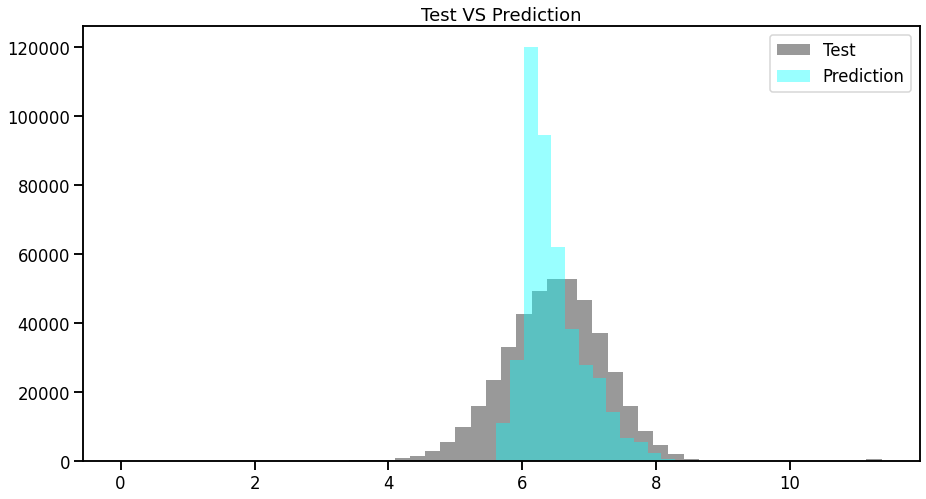

In [190]:
#prediction vs reality check

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(dt_pred, kde=False, color="cyan", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

In [191]:
#implementation of forest algorithm

from sklearn.ensemble import RandomForestRegressor

est_rf = RandomForestRegressor(criterion="mse", n_estimators=5, max_depth=10)
est_rf.fit(X_train, y_train)
rf_pred = est_rf.predict(X_test)
rf_pred

array([6.04521164, 6.77633281, 6.12060576, ..., 6.25392412, 6.73818069,
       7.00546719])

In [192]:
#examining metrics

print ("Training Score : " , est_rf.score(X_train, y_train))

print ("Validation Score : ", est_rf.score(X_test, y_test))

print ("Cross Validation Score : " , cross_val_score(est_rf, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(rf_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(rf_pred, y_test)))

Training Score :  0.32091844329400354
Validation Score :  0.3128540917374112
Cross Validation Score :  0.3139314067633008
R2_Score :  -1.2116767583286188
RMSLE :  0.0977785142949691


Text(0.5, 1.0, 'Test VS Prediction')

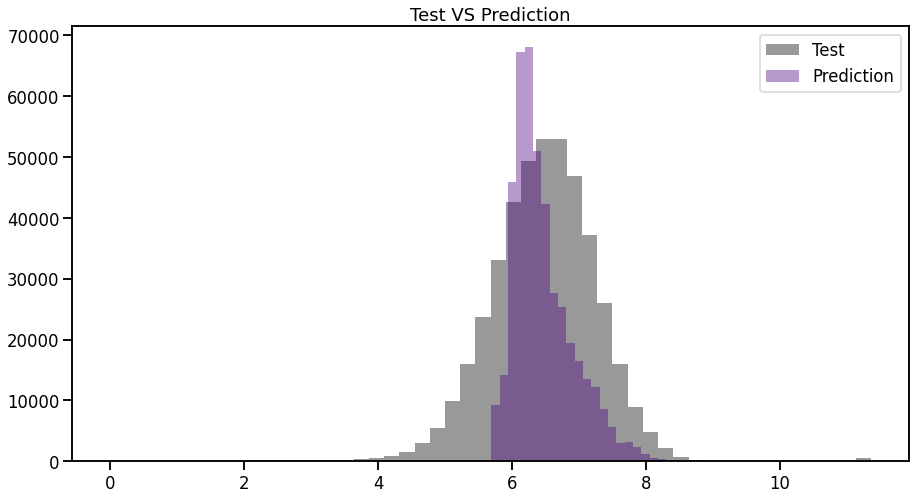

In [193]:
#prediction vs reality check

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(rf_pred, kde=False, color="indigo", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

In [194]:
# Building the neural network

model = Sequential()

# The Input Layer :
model.add(Dense(256, activation='relu', input_dim=X_train.shape[1], activity_regularizer=regularizers.l1(0.01)))
model.add(BatchNormalization())

# The Hidden Layers :
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())

# The Output Layer :
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['mse'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 256)               2048      
                                                                 
 batch_normalization_30 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_31 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_32 (Bat  (None, 64)              

In [195]:
# Checkpoints
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.3f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [196]:
# Training the DNN
history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=20, verbose=1, shuffle=False, validation_split = 0.2,callbacks=callbacks_list)

Epoch 1/20
3179/3191 [============================>.] - ETA: 0s - loss: 3.6640 - mse: 3.5888
Epoch 00001: val_loss improved from inf to 1.36450, saving model to Weights-001--1.364.hdf5
3191/3191 [==============================] - 15s 4ms/step - loss: 3.6511 - mse: 3.5761 - val_loss: 1.3645 - val_mse: 1.3562
Epoch 2/20
3182/3191 [============================>.] - ETA: 0s - loss: 0.1121 - mse: 0.1029
Epoch 00002: val_loss did not improve from 1.36450
3191/3191 [==============================] - 15s 5ms/step - loss: 0.1121 - mse: 0.1029 - val_loss: 4.5507 - val_mse: 4.5415
Epoch 3/20
3190/3191 [============================>.] - ETA: 0s - loss: 0.0955 - mse: 0.0882
Epoch 00003: val_loss did not improve from 1.36450
3191/3191 [==============================] - 16s 5ms/step - loss: 0.0955 - mse: 0.0882 - val_loss: 2.4935 - val_mse: 2.4867
Epoch 4/20
3185/3191 [============================>.] - ETA: 0s - loss: 0.1174 - mse: 0.1138
Epoch 00004: val_loss improved from 1.36450 to 0.14461, saving

In [198]:
wights_file = 'Weights-004--0.145.hdf5' # choose the best checkpoint 
model.load_weights(wights_file) # load it
model.compile(loss='mse', optimizer= 'adam', metrics=['mse'])

In [199]:
# Testing the DNN
model_pred= model.predict(X_test)
model_pred

array([[6.570577 ],
       [7.5182285],
       [6.29736  ],
       ...,
       [7.1241245],
       [7.7241516],
       [6.6299143]], dtype=float32)

In [200]:
#examining metrics 

print ("Training Score : " , model.evaluate(X_train, y_train))

print ("Validation Score : ", model.evaluate(X_test, y_test))

#print ("Cross Validation Score : " , cross_val_score(model, X_train, y_train, cv=5).mean())

print ("R2_Score : ", r2_score(model_pred, y_test))

print ("RMSLE : ", np.sqrt(mean_squared_log_error(model_pred, y_test)))

31908/31908 [==============================] - 42s 1ms/step - loss: 0.1492 - mse: 0.1464
Training Score :  [0.14918163418769836, 0.1463877558708191]
13675/13675 [==============================] - 18s 1ms/step - loss: 0.1476 - mse: 0.1449
Validation Score :  [0.14764641225337982, 0.1448538899421692]
R2_Score :  0.645170359173594
RMSLE :  0.05940220589741495


Text(0.5, 1.0, 'Test VS Prediction')

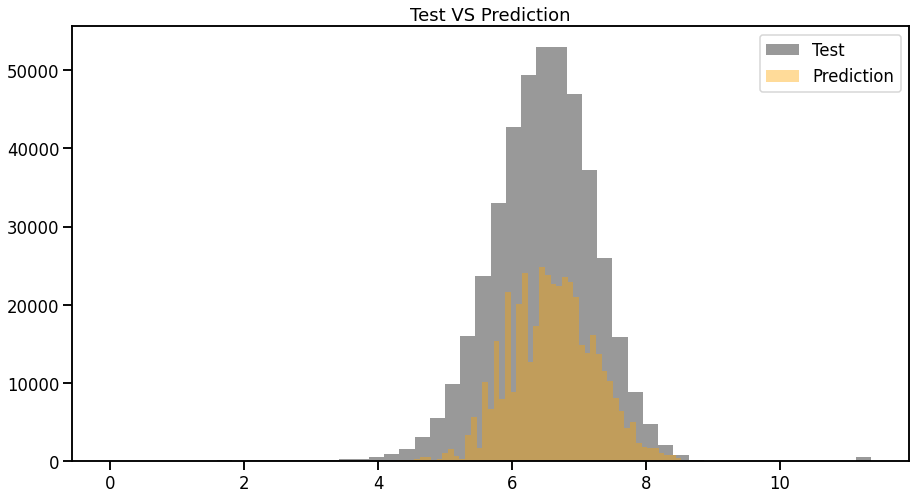

In [201]:
#prediction vs real data

plt.figure(figsize=(15,8))
plt.subplot(1,1,1)
sns.distplot(y_test, kde=False, color="black", label="Test")

plt.subplot(1,1,1)
sns.distplot(model_pred, kde=False, color="orange", label="Prediction")
plt.legend()
plt.title("Test VS Prediction")

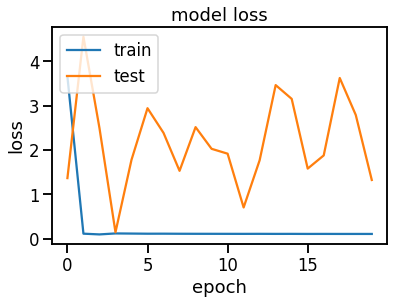

In [202]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'R2 Scores')

<Figure size 720x504 with 0 Axes>

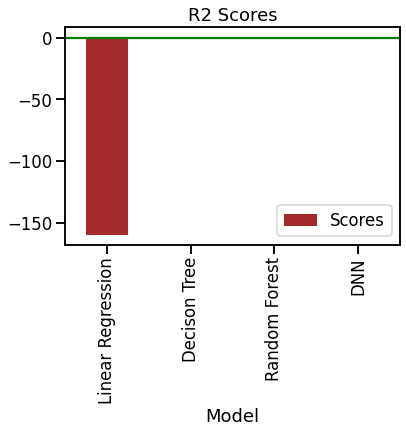

In [203]:
#r2 score plot for all 4 models

plt.figure(figsize=(10,7))
r2 = pd.DataFrame({'Scores':np.array([r2_score(lr_pred, y_test), r2_score(dt_pred, y_test), r2_score(rf_pred, y_test),r2_score(model_pred, y_test)]), 'Model':np.array(['Linear Regression', 'Decison Tree', 'Random Forest', 'DNN'])})
r2.set_index('Model').plot(kind="bar", color="brown")
plt.axhline(y=0, color='g')
plt.title("R2 Scores")

Text(0.5, 1.0, 'R2 Scores')

<Figure size 720x504 with 0 Axes>

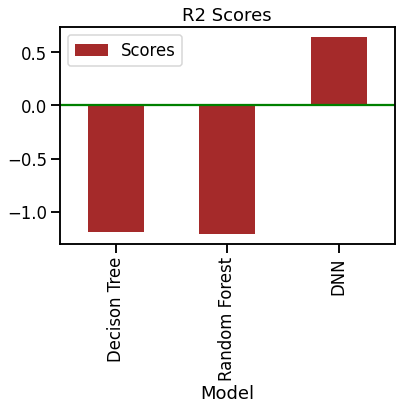

In [204]:
#r2 score plot for 3 models

plt.figure(figsize=(10,7))
r2 = pd.DataFrame({'Scores':np.array([r2_score(dt_pred, y_test), r2_score(rf_pred, y_test),r2_score(model_pred, y_test)]), 'Model':np.array(['Decison Tree', 'Random Forest', 'DNN'])})
r2.set_index('Model').plot(kind="bar", color="brown")
plt.axhline(y=0, color='g')
plt.title("R2 Scores")

Text(0.5, 1.0, 'RMSLE - Lesser is Better')

<Figure size 720x720 with 0 Axes>

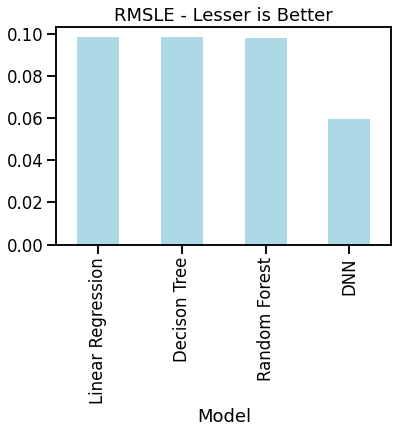

In [205]:
#RMSLE plot

plt.figure(figsize=(10,10))
r2 = pd.DataFrame({'RMSLE':np.array([np.sqrt(mean_squared_log_error(dt_pred, y_test)),np.sqrt(mean_squared_log_error(dt_pred, y_test)), np.sqrt(mean_squared_log_error(rf_pred, y_test)),np.sqrt(mean_squared_log_error(model_pred, y_test))]), 'Model':np.array(['Linear Regression','Decison Tree', 'Random Forest','DNN'])})
r2.set_index('Model').plot(kind="bar", color="lightblue", legend=False)
plt.title("RMSLE - Lesser is Better")